# Projeto de Aprendizagem de Máquina [Kaggle]

Autores:
- Danilo da Costa Pereira
- Dayvid Welles de Castro Oliveira

Projeto desenvolvido durante a disciplina de Aprendizagem de Máquina 2018.2 como requisito parcial para obtenção de nota.

## Análise Exploratória dos Dados

Um dos primeiros passos em um projeto de aprendizagem de máquina compreende a análise do conjunto de dados que será utilizado para construir o algoritmo de aprendizagem. Sendo assim, iniciaremos levantando informações básicas sobre a base de dados a ser utilizada.

Os dados são oriundos da competição Talkingdata adtracking fraud detection, realizada através da plataforma do Kaggle. O propósito da tarefa é predizer se um usuário irá realizar ou não o download de um aplicativo ao clicar em seu anúncio (AD). Os dados são disponibilizados divididos em conjuntos de treinamento e teste, com o primeiro conjunto rotulado. Sendo assim, naturalmente se trata de uma tarefa de aprendizagem supevisionada.

Link para download da base: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection

Essa é a descrição da base contida no site da competição:

- ip: endereço de ip do click.
- app: o ip do aplicativo para marketing.
- device: id do tipo de dispositivo do usuário (ex.: iphone 6 plus, iphone 7, huawei mate 7, etc.)
- os: o id da versão do OS do celular do usuário.
- channel: o id do canal do publicador de anúncios para celular.
- click_time: timestamp do click (UTC)
- attributed_time: se o usuário fez o download do aplicativo depois do click, essa é a hora do download.
- is_attributed: a variável de saída que será predita, indicando se o aplicativo foi baixado ou não.


Primeiramente vamos importar todas as bibliotecas necessárias para a execução desse projeto e realizar a leitura da base de dados para verificarmos os seus atributos. Para essa demonstração utilizaremos uma pequena amostra do conjunto completo de treinamento disponibilizada pela competição (arquvo train_sample.csv disponível no site).
A leitura e processamento da base de dados será conduzida através da biblioteca Pandas e o numpy.

In [78]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import datetime
import time
import seaborn as sns
import numpy as np
import lightgbm as lgb
import gc
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin
from hyperopt import Trials
from matplotlib import pyplot as plt
from matplotlib import rcParams
from PIL import Image
rcParams.update({'figure.autolayout': True})



In [ ]:
training_path = "data/train_sample.csv"
train = pd.read_csv(training_path)

print("Training data information")
print(train.info())
print("\n")
print("Basic statistical measures")
print(train.describe())

Como é possível verificar, a base de dados possui 8 atributos, sendo o último atributo "is_attributed" a variável de saída indicando se foi ou não realizado o download. As estatísticas básicas geradas nos permitem perceber que a grande maioria das amostras são negatives, visto a média de 0.002 para a variável "is_attributed". 

A seguir será disposta uma descrição visual pode deixar mais clara essa disparidade. 

/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


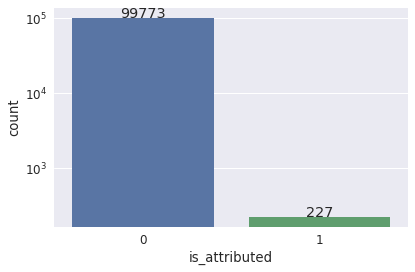

In [9]:
# visual description of the output variable

y_plot = sns.countplot(x='is_attributed', data=train, log=True)

uniques = list(train['is_attributed'].value_counts())
for p, uniq in zip(y_plot.patches, uniques):
    height = p.get_height()
    y_plot.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            uniq,
            ha="center")
plt.show()

O gráfico nos permite ver com clareza o quão a base de dados é desbalanceada. Sendo assim, na próxima fase, na qual será realizado o pré-processamento dessa base de dados, esse fator deve ser levado em conta. Também é possível visualizar o número único de valores para cada características:

/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


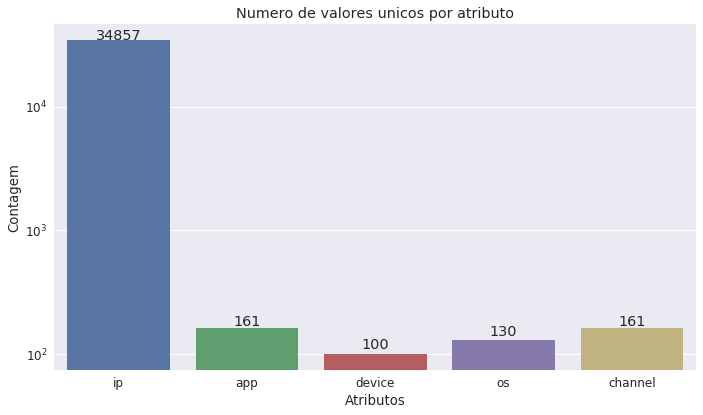

In [10]:
# visual description of the unique counts

feature_names = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in feature_names] 
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)
ax = sns.barplot(feature_names, uniques, log=True) # set log to visualize better the counts across different variables with different magnitudes
ax.set(xlabel='Atributos', ylabel='Contagem', title='Numero de valores unicos por atributo'.format(len(train)))
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    index = p.get_x() + p.get_width() / 2.
    ax.text(index, height + 10, uniq, ha="center") 
plt.show()

## Pré-Processamento de Dados 

Na fase exploratória de dados observamos os atributos presentes na base de dados, bem como identificamos um grau de desbalanceamento elevado. Agora, realizaremos a leitura dos conjuntos de treino e teste de forma a atenuar o desbalanceamento e prepararmos os conjuntos de treinamento, validação e teste que serão utilizados para o desenvolvimento do modelo.

Iniciaremos definindo os atributos em forma de listas e a tipo de dados dos atributos de treino:

In [ ]:
train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8'
}

A abordagem adotada nesse trabalho para a avaliação do modelo é o random subsampling (ou repeated holdout), visto que esta é uma base grande. A partir do conjunto de treinamento, selecionaremos aleatoriamente cinco conjuntos de treino e validação com amostras selecionadas aleatoriamente. A porcentagem de exemplos reservadas para validação será de 10%, com a divisão realizada de forma estratificada validation_holdout = 0.1 para garantir distribuição de classes semelhantes entre os diferentes conjuntos.

Como os exemplos positivos são minoria, todos eles vão ser utilizados e realizaremos um random undersampling da parte negativa de forma que a quantidade de amostras para as duas classes sejam iguais. Porém, apesar dos exemplos negativos serem selecionados de forma aleatória, esse seleção é baseada em pequenos chunks. A base de dados é disponibilizada de forma ordenada com respeito ao atributo click_time, então para mantermos amostras positivas e negativas com o horário de click semelhantes, a seleção dos exemplos negativos é realizada de forma aleatória com base em pequenos chunks do conjunto de treinamento. Isto é, para cada pequena porção de dados lidas iterativamente exemplos positivos, nós selecionamos uma quantidade equivalente de exemplos negativos dentro da porção.

A seguir, definimos o método para gerar os conjuntos seguindo a abordagem descrita.

In [ ]:
validation_holdout = 0.1
nb_datasets = 5
for i in range(1, nb_datasets+1):
    # Training data
    chunksize = 10000 # 100000000
    iter_csv = pd.read_csv('data/train.csv', iterator=True, chunksize=chunksize, usecols=train_columns, dtype=dtypes)
    final_positives = pd.DataFrame()
    final_negatives = pd.DataFrame()

    for idx, chunk in enumerate(iter_csv):
        positives_indexis = chunk[chunk['is_attributed'] == 1].index.values
        negatives_indexis = chunk[chunk['is_attributed'] == 0].index.values

        if len(positives_indexis) == 0:
                continue

        assert len(negatives_indexis) > len(positives_indexis)

        positives = chunk.loc[positives_indexis]

        negative_indexis_filtered = np.random.choice(negatives_indexis, len(positives), replace=False)
        negatives = chunk.loc[negative_indexis_filtered]

        final_positives = pd.concat([final_positives, positives])
        final_negatives = pd.concat([final_negatives, negatives])
                
    nb_samples = len(final_positives + final_negatives)

    validation_positives = np.random.choice(final_positives.index.values, int(np.round(nb_samples*validation_holdout*0.5)), replace=False)
    validation_negatives = np.random.choice(final_negatives.index.values, int(np.round(nb_samples*validation_holdout*0.5)), replace=False)
    validation = pd.concat([final_positives.loc[validation_positives], final_negatives.loc[validation_negatives]])
    validation = validation.reset_index(drop=True)

    final_positives = final_positives.drop(validation_positives)
    final_negatives = final_negatives.drop(validation_negatives)

    training = pd.concat([final_positives, final_negatives], axis=0)
    training = training.sort_values('click_time')
    training = training.reset_index(drop=True)

    print("\nTraining data:")
    print(training.shape )
    print(training.head() )
    print("Saving training data...")
    training.to_csv('data/train_balanced_sample_{}_SANITYCHECK.csv'.format(i), index=False)

    print("\nValidation data:")
    print(validation.shape )
    print(validation.head() )
    print("Saving validation data...")
    validation.to_csv('data/valid_balanced_sample_{}_SANITYCHECK.csv'.format(i), index=False)

#### Considerações sobre pré-processamento

Como visto acima, para as variáveis categóricas como o ip, device e os, não foi realizado nenhum pré-processamento como por exemplo o tradicional one-hot encoding. O motivo é que essas características que tem alta cardinalidade e a ferramenta selecionada para o treinamento dos modelos de classificação tem uma implementação otimizada para reduzir o custo computacional, bastando apenas indicar durante o treino quais são as características do tipo categóricas. Além disso, os atributos não foram normalizados com uma faixa de valores entre 0 e 1 ou média 0 e desvio padrão 1 visto que essas normalizações afetaram de forma negativa o desempenho do classificador nos experimentos preliminares.

### Engenharia de Características

Com esse procedimento é possível gerar os conjuntos de treino e validação. Nos próximos passos, nós vamos definir novas características a partir dos sete atributos originais. O primeiro passo será decompor o atributo "click_time" que possui o timestamp completo do momento do click no aplicativo. 

In [ ]:

def add_time_features(df):
    # Extract different time granulatities
    df['day'] = df['click_time'].dt.day.astype('uint8')
    df['hour'] = df['click_time'].dt.hour.astype('uint8')
    df['minute'] = df['click_time'].dt.minute.astype('uint8')
    df['second'] = df['click_time'].dt.second.astype('uint8')
    df.drop('click_time', 1, inplace=True)
    return df

Assim, o atributo click_time dá lugar aos atributos day, hour, minute e second. A seguir, realizaremos um procedimento básico em engenharia de características que trata-se de criar novas características baseadas em simples contagens. Para isso, vamos adicionar contagens de amostras a partir de regras de agrupamento. Por exemplo, podemos agrupar a base de dados a partir dos ips contidos na base e assim para cada ip eu posso contar o número de canais associados com ele. Da mesma forma, posso agrupar a base de acordo com os aplicativos nela existentes e para cada aplicativo contar o número de canais associados com ele.

In [ ]:
def add_groupby_features(df):
    ''' 
    Pandas grouping functionality
    df.groupby(by=grouping_columns)[columns_to_show].function()

    function -> count, size, mean, var
    '''

    def __add(df_current, groupby_crit, cols_to_select, function, feature_name):
        groupby_obj = df.groupby(groupby_crit)[cols_to_select].agg(function)
        groupby_obj = groupby_obj.reset_index().rename(index=str, columns={cols_to_select[0]: feature_name})
        return df_current.merge(groupby_obj, on=groupby_crit, how='left', sort=False)

    ratio_ips_by_users = lambda x: float(len(x)) / len(x.unique())

    grouping_strategies = {
        'app_popularity': [['app'], ['channel'], 'count'], # Aplicativo muito popular?
        'clicks_per_ip': [['ip'], ['channel'], 'count'], # Usuários bots? muitos clicks vindo de um ip
         # other extra combinations
        'ip_app_ch_h': [['ip','app', 'channel'], ['hour'], 'count'], # group by ip-app-channel
        'ip_day_hour_c': [['ip','day', 'hour'], ['channel'], 'count'], # group by ip-day-hour
        'ip_app_os_ch_c': [['ip', 'app', 'os'], ['channel'], 'count'] # group by ip-app-os
    }

    for feature_name, groupby_info in grouping_strategies.items():
        groupby_criteria = groupby_info[0]
        features_to_select = groupby_info[1]
        function = groupby_info[2]
        df = __add(df, groupby_criteria, features_to_select, function, feature_name)
    
    df['app_popularity'] = df['app_popularity'].astype('uint16')
    df['clicks_per_ip'] = df['clicks_per_ip'].astype('uint16')
    df['ip_app_ch_h'] = df['ip_app_ch_h'].astype('uint16')
    df['ip_day_hour_c'] = df['ip_day_hour_c'].astype('uint16')
    df['ip_app_os_ch_c'] = df['ip_app_os_ch_c'].astype('uint16')

    return df

## Seleção e Treinamento do Modelo de Aprendizagem

Terminada a etapa de pré-processamento e engenharia de características, podemos prosseguir com a construção de um espaço de hipóteses e selecionar uma configuração adequada para o nosso algoritmo de aprendizagem. A métrica definida pela competição para avaliar o desempenho dos modelos é a área sobre a curva ROC (AUC). Nesse trabalho utilizaremos um algoritmo de aprendizagem baseado em árvores de decisão. Especificamente, será utilizada uma abordagem ensemble baseada em Gradient Boosting Decision Trees. As motivações para o uso dessa abordagem são: i) é uma abordagem que já se mostrou eficiente em problemas de predição de click para ads [1], ii) árvores de decisão é uma boa opção quando as instâncias são representadas por pares atributo-valor, há um conjunto fixo de atributos e seus valores. iii) apresenta uma boa velocidade de treinamento e classificação para bases grandes iv) Gradient Boosting é uma das abordagens mais dominantes nas competições do Kaggle.

A implementação utilizada para Gradient Boosting escolhida é a do LightGBM, visto que é otimizada para manter uma alta capacidade de generalização com maior velocidade. Outras implementações como a do sklearn e do XGBoosting são mais lentas e requerem mais memória. 

[1] Matthew Richardson, Ewa Dominowska, and Robert Ragno. Predicting clicks: estimating the click-through rate for new ads. In Proceedings of the 16th international conference on World Wide Web, pages 521–530. ACM, 2007.

Começaremos então realizando a leitura de um dos cinco conjuntos de treinamento e validação criados anteriormente e o conjunto de teste. Para isso, é necessário definir as colunas que serão selecionadas do arquivo .csv. 

In [60]:
dtypes = {
    'ip'                    : 'uint32',
    'app'                   : 'uint16',
    'device'                : 'uint16',
    'os'                    : 'uint16',
    'channel'               : 'uint16',
    'is_attributed'         : 'uint8',
    'click_id'              : 'uint32'
    }

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']

training_path = "data/train_balanced_sample_1.csv"
validation_path = "data/valid_balanced_sample_1.csv"
testing_path = "data/test.csv"

In [61]:
print('loading train data...')
train_df = pd.read_csv(training_path, dtype=dtypes, usecols=train_columns)
train_df['click_time'] = pd.to_datetime(train_df['click_time'])

print('loading valid data...')
valid_df = pd.read_csv(validation_path, dtype=dtypes, usecols=train_columns)
valid_df['click_time'] = pd.to_datetime(valid_df['click_time'])

print('loading test data...')
test_df = pd.read_csv(testing_path, dtype=dtypes, usecols=test_columns)
test_df['click_time'] = pd.to_datetime(test_df['click_time'])

print('done!')

loading train data...
loading valid data...
loading test data...
done!


Em seguida vamos separar o rótulo de saída do conjunto de características que serão utilizadas para o treino

In [62]:
target = 'is_attributed'

y_train_df = train_df[target]
train_df.drop([target], axis=1, inplace=True)

y_valid_df = valid_df[target]
valid_df.drop([target], axis=1, inplace=True)

print("done!")

done!


Como a base de testes possui um ID para identificar cada amostra durante a submissão, por hora devemos removê-lo visto que por hora a base será utilizada somente para adicionarmos os métodos de engenharia de características defnidos anteriormente.

In [63]:
test_df.drop(['click_id'], axis=1, inplace=True) # remover o id de submissão para feature engineering agrupada com treino e validação

Agora realizaremos o agrupamento dos sub-conjuntos de dados para adicionar as características de uma única vez. Além de adicionar as características, os atributos nulos serão preenchidos com a média dos valores não-nulos *[essa modificação não apresentou efeitos na performance visto que o LightGBM trata esses casos, porém, mantivemos a modificação apenas para fins de demonstração]*.

In [64]:
nb_train_samples = len(train_df)
nb_valid_samples = len(valid_df)

merge = pd.concat([train_df, valid_df, test_df], sort=False)
merge = add_time_features(merge)
merge = add_groupby_features(merge)
merge = merge.fillna(merge.mean())

print('done!')

done!


Em seguida, podemos retornar para os conjuntos separados e prosseguir para o treinamento. Além disso,o vamos definir quais são as variáveis categóricas agora que foi finalizada a engenharia de características.

In [65]:
x_train_df, x_valid_df, x_test_df = merge.iloc[:nb_train_samples, :], merge.iloc[nb_train_samples:nb_train_samples+nb_valid_samples, :], merge.iloc[nb_train_samples+nb_valid_samples:, :]
x_train_df.index  = train_df.index # corrigir os indices que foram alterados depois do merge
x_valid_df.index  = valid_df.index # corrigir os indices que foram alterados depois do merge

print("train size: ", len(x_train_df))
print("valid size: ", len(x_valid_df))
print("test size : ", len(x_test_df))

# del train_df, valid_df, test_df
gc.collect()

all_features = list(x_train_df.columns)
categorical_features = ['ip', 'app', 'device', 'os', 'channel']
datatime_features = ['day', 'hour', 'minute', 'second']
categorical_features.extend(datatime_features)

print ("done!")

('train size: ', 822322)
('valid size: ', 91370)
('test size : ', 18790470)
done!


Os dados que estão no formato de dataframe do pandas devem ser convertidos para o formato aceitado pelo LightGBM

In [66]:
train_loader = lgb.Dataset(x_train_df.values, label=y_train_df.values,
                    feature_name=all_features,
                    free_raw_data=False
                )
valid_loader = lgb.Dataset(x_valid_df.values, label=y_valid_df.values,
                        feature_name=all_features,
                        free_raw_data=False
                )
print ('done!')

done!


### Otimização dos Hiperparâmetros

Finalmente, com todos os preparativos concluídos podemos realizar o treinamento dos modelos. Vamos definir um espaço de busca dos melhores parâmetros para o Gradient Boosting Decision Tree (GBDT). Essa otimização será conduzida através da ferramenta Hyperopt.

Primeiramente precisamos definir os parâmetros que serão fixos, visto que precisamos definir um escopo viável para os nosso experimentos.

In [67]:
fixed_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric':'auc',
    'learning_rate': 0.05,    
    'verbose': -1,
    'nthread': 4,
    'bagging_freq' : 1
}

opt_params = dict(**fixed_params)

Em seguida vamos definir a função objetivo para otimização dos parâmetros. O método deve receber um conjunto de parâmetros e retornar o desempenho do modelo GDBT criado com os parâmetros recebidos. Como buscamos minimizar a função objetivo, na verdade retornamos 1 - AUC.

In [68]:
def objective(params):

    opt_params.update(
        {    
        # 'num_leaves': (2 ** int(params['max_depth'])) - 1,
        'num_leaves': int(params['num_leaves']),
        'max_depth': int(params['max_depth']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction']),
        'min_child_samples': int(params['min_child_samples']),
        'min_child_weight': '{:.3f}'.format(params['min_child_weight']),
        }
    )
   
    results = {}

    trial = lgb.train(opt_params, 
                     train_loader, 
                     valid_sets=[train_loader, valid_loader], 
                     valid_names=['train','valid'], 
                     evals_result=results, 
                     num_boost_round=500,
                     early_stopping_rounds=30,
                     verbose_eval=0,
                     categorical_feature=categorical_features
                     )

    n_estimators = trial.best_iteration
    train_score = results['train']['auc'][n_estimators-1]
    valid_score = results['valid']['auc'][n_estimators-1]

    print("train_auc: {:.4f} valid_auc: {:.4f} params {}".format(train_score, valid_score, opt_params))
    return 1 - valid_score

Com a função objetivo criada, podemos então definir o espaço de busca dos parâmetros. Avaliaremos diferentes configurações para o número de folhas da árvore, a profundidade máxima, a fração de características utilizada para treinar cada estimador, a fração de amostras que serão selecionadas e por fim características relacionadas ao número mínimo de amostras em um nó para evitar overfitting.

In [69]:
space = {
    'num_leaves': hp.choice('num_leaves', np.arange(8, 56, 8, dtype=int)),
    'max_depth': hp.choice('max_depth', [6, 8, 10]),
    'feature_fraction': hp.uniform('feature_fraction', 0.6, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.8, 1.0),
    'min_child_samples': hp.choice('min_child_samples', np.arange(10, 25, 5, dtype=int)), #  something like "stop trying to split once your sample size in a node goes below a given threshold"
    'min_child_weight' : hp.uniform('min_child_weight', 2, 5),
}

Em seguida, podemos fazer a chamada do método que realizará a busca, serão realizados 80 testes de configurações selecionadas aleatoriamente.

In [70]:
best_optimized = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=80)

best_params = space_eval(space, best_optimized)
best_params = dict(fixed_params, **best_params)

/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app', 'channel', 'day', 'device', 'hour', 'ip', 'minute', 'os', 'second']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app', 'channel', 'day', 'device', 'hour', 'ip', 'minute', 'os', 'second']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


train_auc: 0.9771 valid_auc: 0.9752 params {'num_leaves': 32, 'verbose': -1, 'feature_fraction': '0.895', 'bagging_fraction': '0.891', 'learning_rate': 0.05, 'nthread': 4, 'min_child_weight': '4.603', 'max_depth': 6, 'objective': 'binary', 'min_child_samples': 20, 'bagging_freq': 1, 'metric': 'auc', 'boosting_type': 'gbdt'}
train_auc: 0.9775 valid_auc: 0.9751 params {'num_leaves': 16, 'verbose': -1, 'feature_fraction': '0.868', 'bagging_fraction': '0.946', 'learning_rate': 0.05, 'nthread': 4, 'min_child_weight': '4.126', 'max_depth': 10, 'objective': 'binary', 'min_child_samples': 20, 'bagging_freq': 1, 'metric': 'auc', 'boosting_type': 'gbdt'}
train_auc: 0.9759 valid_auc: 0.9744 params {'num_leaves': 8, 'verbose': -1, 'feature_fraction': '0.944', 'bagging_fraction': '0.882', 'learning_rate': 0.05, 'nthread': 4, 'min_child_weight': '2.960', 'max_depth': 8, 'objective': 'binary', 'min_child_samples': 20, 'bagging_freq': 1, 'metric': 'auc', 'boosting_type': 'gbdt'}
train_auc: 0.9794 vali

train_auc: 0.9800 valid_auc: 0.9759 params {'num_leaves': 40, 'verbose': -1, 'feature_fraction': '0.644', 'bagging_fraction': '0.932', 'learning_rate': 0.05, 'nthread': 4, 'min_child_weight': '3.543', 'max_depth': 10, 'objective': 'binary', 'min_child_samples': 20, 'bagging_freq': 1, 'metric': 'auc', 'boosting_type': 'gbdt'}
train_auc: 0.9788 valid_auc: 0.9759 params {'num_leaves': 40, 'verbose': -1, 'feature_fraction': '0.727', 'bagging_fraction': '0.980', 'learning_rate': 0.05, 'nthread': 4, 'min_child_weight': '2.977', 'max_depth': 10, 'objective': 'binary', 'min_child_samples': 20, 'bagging_freq': 1, 'metric': 'auc', 'boosting_type': 'gbdt'}
train_auc: 0.9785 valid_auc: 0.9757 params {'num_leaves': 40, 'verbose': -1, 'feature_fraction': '0.706', 'bagging_fraction': '0.811', 'learning_rate': 0.05, 'nthread': 4, 'min_child_weight': '2.276', 'max_depth': 10, 'objective': 'binary', 'min_child_samples': 10, 'bagging_freq': 1, 'metric': 'auc', 'boosting_type': 'gbdt'}
train_auc: 0.9793 v

train_auc: 0.9791 valid_auc: 0.9757 params {'num_leaves': 32, 'verbose': -1, 'feature_fraction': '0.756', 'bagging_fraction': '0.906', 'learning_rate': 0.05, 'nthread': 4, 'min_child_weight': '4.223', 'max_depth': 8, 'objective': 'binary', 'min_child_samples': 15, 'bagging_freq': 1, 'metric': 'auc', 'boosting_type': 'gbdt'}
train_auc: 0.9800 valid_auc: 0.9759 params {'num_leaves': 40, 'verbose': -1, 'feature_fraction': '0.660', 'bagging_fraction': '0.921', 'learning_rate': 0.05, 'nthread': 4, 'min_child_weight': '3.237', 'max_depth': 10, 'objective': 'binary', 'min_child_samples': 20, 'bagging_freq': 1, 'metric': 'auc', 'boosting_type': 'gbdt'}
train_auc: 0.9784 valid_auc: 0.9756 params {'num_leaves': 16, 'verbose': -1, 'feature_fraction': '0.635', 'bagging_fraction': '0.977', 'learning_rate': 0.05, 'nthread': 4, 'min_child_weight': '2.883', 'max_depth': 6, 'objective': 'binary', 'min_child_samples': 10, 'bagging_freq': 1, 'metric': 'auc', 'boosting_type': 'gbdt'}
train_auc: 0.9781 val

train_auc: 0.9793 valid_auc: 0.9757 params {'num_leaves': 24, 'verbose': -1, 'feature_fraction': '0.697', 'bagging_fraction': '0.920', 'learning_rate': 0.05, 'nthread': 4, 'min_child_weight': '3.190', 'max_depth': 10, 'objective': 'binary', 'min_child_samples': 10, 'bagging_freq': 1, 'metric': 'auc', 'boosting_type': 'gbdt'}
train_auc: 0.9802 valid_auc: 0.9759 params {'num_leaves': 48, 'verbose': -1, 'feature_fraction': '0.766', 'bagging_fraction': '0.997', 'learning_rate': 0.05, 'nthread': 4, 'min_child_weight': '4.016', 'max_depth': 8, 'objective': 'binary', 'min_child_samples': 10, 'bagging_freq': 1, 'metric': 'auc', 'boosting_type': 'gbdt'}


Após chamar o método de otimização, podemos exibir os parâmetros finais encontrados



In [71]:
print("#" * 50)
print("Best Params!\n")
print(best_params)
with open('best_params_{}.log'.format(datetime.datetime.now()), 'w') as f:
    f.write(str(best_params))

##################################################
Best Params!

{'num_leaves': 40, 'verbose': -1, 'feature_fraction': 0.6101008802332486, 'bagging_fraction': 0.9946666122358022, 'learning_rate': 0.05, 'nthread': 4, 'min_child_weight': 4.993679701619147, 'max_depth': 10, 'objective': 'binary', 'min_child_samples': 20, 'bagging_freq': 1, 'metric': 'auc', 'boosting_type': 'gbdt'}


## Avaliação Final e Combinação dos Modelos

No início deste trabalho nós criados cinco conjuntos de treino e validação utilizando random undersampling da parte negativa com divisão estratificada. Nessa fase do trabalho, após identificarmos os melhores parâmetros para um dos conjuntos, vamos utilizar esses parâmetros para treinar os cinco modelos e realizar a predição utilizando a base de testes. Ao fim, nós empregamos um combinador algébrico baseado na média das cinco predições para obter a estimação final.

Começaremos limpando a memória deletando estruturas de dados que não serão mais utilizadas.

In [72]:
del train_df
del valid_df
del train_loader
del valid_loader
gc.collect()

543

Em seguida, a base de testes deve ser carregada.

In [73]:
print('loading test data...')
test_df_reuse = pd.read_csv(testing_path, dtype=dtypes, usecols=test_columns)
test_df_reuse['click_time'] = pd.to_datetime(test_df_reuse['click_time'])
click_ids = test_df_reuse['click_id']

test_df_reuse.drop(['click_id'], axis=1, inplace=True) # remover o id de submissão para feature engineering agrupada com treino e validação
print('done!')

loading test data...
done!


É necessário também criar uma estrutura de dados para armazenar a média das predições de cada um dos cinco modelos que serão treinados.

In [74]:
sub_ensemble = pd.DataFrame()
sub_ensemble['click_id'] = click_ids.astype('int')
sub_ensemble['is_attributed'] = 0

O procedimento para o treinamento de cada um dos cinco modelos segue a mesma lógica já apresentada anteriormente para a otimização dos parâmeotrs. Ao final do treinamento (método lgb.train), a avaliação individual do GBDT com a base de testes é conduzida e armazenada. Além disso, as importâncias das características extraídas das árvores de decisão são exibidas em forma de um gráfico, com isso é possível visualizar as características que foram mais dominantes e assim é possível re-executar a pipeline proposta nesse trabalho com diferentes configurações.

loading train data...
loading valid data...


/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app', 'channel', 'day', 'device', 'hour', 'ip', 'minute', 'os', 'second']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app', 'channel', 'day', 'device', 'hour', 'ip', 'minute', 'os', 'second']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[100]	training's auc: 0.975868	valid_1's auc: 0.974673
[200]	training's auc: 0.978734	valid_1's auc: 0.975899
[300]	training's auc: 0.980069	valid_1's auc: 0.976043
Early stopping, best iteration is:
[291]	training's auc: 0.979982	valid_1's auc: 0.976055
Model 1 concluído
loading train data...
loading valid data...


/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app', 'channel', 'day', 'device', 'hour', 'ip', 'minute', 'os', 'second']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app', 'channel', 'day', 'device', 'hour', 'ip', 'minute', 'os', 'second']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[100]	training's auc: 0.975729	valid_1's auc: 0.974177
[200]	training's auc: 0.978613	valid_1's auc: 0.975407
[300]	training's auc: 0.979944	valid_1's auc: 0.97556
Early stopping, best iteration is:
[290]	training's auc: 0.979842	valid_1's auc: 0.97557
Model 2 concluído
loading train data...
loading valid data...


/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app', 'channel', 'day', 'device', 'hour', 'ip', 'minute', 'os', 'second']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app', 'channel', 'day', 'device', 'hour', 'ip', 'minute', 'os', 'second']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[100]	training's auc: 0.975904	valid_1's auc: 0.97428
[200]	training's auc: 0.978711	valid_1's auc: 0.975426
[300]	training's auc: 0.980054	valid_1's auc: 0.975637
Early stopping, best iteration is:
[290]	training's auc: 0.979949	valid_1's auc: 0.975645
Model 3 concluído
loading train data...
loading valid data...


/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app', 'channel', 'day', 'device', 'hour', 'ip', 'minute', 'os', 'second']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app', 'channel', 'day', 'device', 'hour', 'ip', 'minute', 'os', 'second']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[100]	training's auc: 0.975836	valid_1's auc: 0.973832
[200]	training's auc: 0.978689	valid_1's auc: 0.975136
[300]	training's auc: 0.980044	valid_1's auc: 0.9753
Early stopping, best iteration is:
[291]	training's auc: 0.97995	valid_1's auc: 0.975311
Model 4 concluído
loading train data...
loading valid data...


/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app', 'channel', 'day', 'device', 'hour', 'ip', 'minute', 'os', 'second']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app', 'channel', 'day', 'device', 'hour', 'ip', 'minute', 'os', 'second']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[100]	training's auc: 0.975831	valid_1's auc: 0.973941
[200]	training's auc: 0.978713	valid_1's auc: 0.975087
[300]	training's auc: 0.980009	valid_1's auc: 0.975225
Early stopping, best iteration is:
[290]	training's auc: 0.979907	valid_1's auc: 0.975235
Model 5 concluído


/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


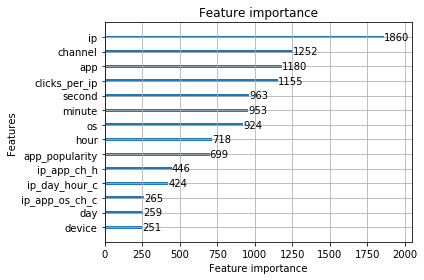

/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


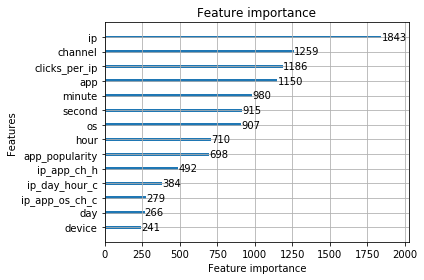

/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


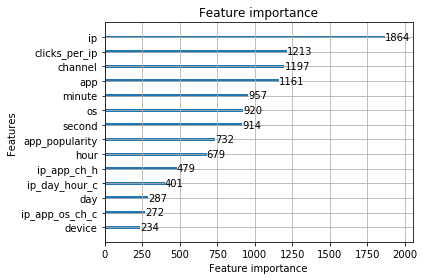

/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


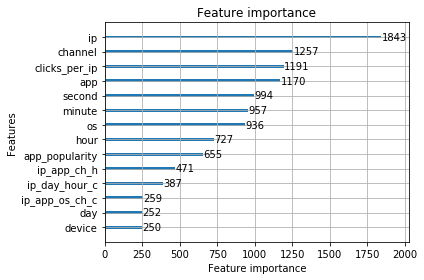

/home/dayvidwelles/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


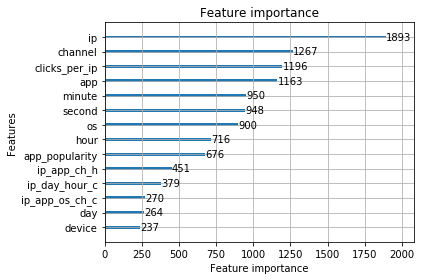

In [82]:
nb_datasets = 5
for i in range(1, nb_datasets+1):
    train_data = 'data/train_balanced_sample_{}.csv'.format(i)
    valid_data = 'data/valid_balanced_sample_{}.csv'.format(i)

    print('loading train data...')
    train_df = pd.read_csv(train_data, dtype=dtypes, usecols=train_columns)
    train_df['click_time'] = pd.to_datetime(train_df['click_time'])

    y_train_df = train_df['is_attributed']
    train_df.drop(['is_attributed'], axis=1, inplace=True)

    print('loading valid data...')
    valid_df = pd.read_csv(valid_data, dtype=dtypes, usecols=train_columns)
    valid_df['click_time'] = pd.to_datetime(valid_df['click_time'])

    y_valid_df = valid_df['is_attributed']
    valid_df.drop(['is_attributed'], axis=1, inplace=True)

    nb_train_samples = len(train_df)
    nb_valid_samples = len(valid_df)

    merge = pd.concat([train_df, valid_df, test_df_reuse], sort=False)
    merge = add_time_features(merge)
    merge = add_groupby_features(merge)
    merge = merge.fillna(merge.mean())

    x_train_df, x_valid_df, x_test_df = merge.iloc[:nb_train_samples, :], merge.iloc[nb_train_samples:nb_train_samples+nb_valid_samples, :], merge.iloc[nb_train_samples+nb_valid_samples:, :]
    x_train_df.index  = train_df.index # corrigir os indices que foram alterados depois do merge
    x_valid_df.index  = valid_df.index # corrigir os indices que foram alterados depois do merge
    x_test_df.index = test_df_reuse.index # corrigir os indices que foram alterados depois do merge

    del merge
    gc.collect()

    # x_train_full = pd.concat([x_train_df, x_valid_df])

    train_loader = lgb.Dataset(x_train_df[all_features].values, label=y_train_df.values,
                        feature_name=all_features,
                        free_raw_data=False
                    )
    
    valid_loader = lgb.Dataset(x_valid_df[all_features].values, label=y_valid_df.values,
                        feature_name=all_features,
                        free_raw_data=False
                    )

    current_model = lgb.train(best_params, 
                        train_loader, 
                        valid_sets=[train_loader, valid_loader],
                        num_boost_round=500,
                        early_stopping_rounds=30,
                        verbose_eval=100,
                        categorical_feature=categorical_features
                    )

    del train_loader
    del valid_loader
    del train_df
    del valid_df
    gc.collect()

    predictions = current_model.predict(x_test_df[all_features])

    sub_ensemble['is_attributed'] += predictions

    sub_individual = pd.DataFrame()
    sub_individual['click_id'] = click_ids.astype('int')
    sub_individual['is_attributed'] = predictions
    sub_individual.to_csv('sub_lgb_balanced_individual_{}.csv'.format(i),index=False)

    current_model.save_model('sub_lgb_balanced_individual_{}.txt'.format(i))
    ax = lgb.plot_importance(current_model, max_num_features=100)
    plt.savefig('sub_lgb_balanced_individual_{}.png'.format(i))
    
    print("Model {} concluído".format(i))


### Finalizando a submissão conjunta

In [84]:
sub_ensemble['is_attributed'] = sub_ensemble['is_attributed'] / 5. # average predictions

print("writing...")
sub_ensemble.to_csv('sub_lgb_balanced_ensemble_{}.csv'.format(datetime.datetime.now()),index=False)
print("done...")

writing...
done...
